In [ ]:
# Install required packages
!pip install labml
!pip install labml_nn

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as npport
from labml.logger import inspect


In [2]:
# Implementation and Testing of RotaryPositionalEmbeddings

class RotaryPositionalEmbeddings(nn.Module):
    """
    ## Rotary Positional Embeddings (RoPE) Module

    Rotary encoding transforms pairs of features by rotating them in the 2D plane.
    This class implements the Rotary Positional Embeddings as described in the RoFormer paper.
    """

    def __init__(self, d: int, base: int = 10_000):
        """
        Initialize the RotaryPositionalEmbeddings.

        Args:
            d (int): Number of features. Must be even as features are paired.
            base (int, optional): Base value for calculating theta. Defaults to 10_000.
        """
        super().__init__()

        self.base = base
        self.d = d
        self.cos_cached = None
        self.sin_cached = None

    def _build_cache(self, x: torch.Tensor):
        """
        Cache the cosine and sine values based on the input tensor `x` to optimize computations.

        Args:
            x (torch.Tensor): Input tensor of shape `[seq_len, batch_size, n_heads, d]`.
        """
        # Return if cache is already built and sufficient
        if self.cos_cached is not None and x.shape[0] <= self.cos_cached.shape[0]:
            return

        # Get sequence length
        seq_len = x.shape[0]

        # Calculate theta_i = 10000^{-2(i)/d} for each pair of features
        theta = 1. / (self.base ** (torch.arange(0, self.d, 2).float() / self.d)).to(x.device)

        # Create position indexes [0, 1, ..., seq_len - 1]
        seq_idx = torch.arange(seq_len, device=x.device).float()

        # Calculate the product of position index and theta_i
        idx_theta = torch.einsum('n,d->nd', seq_idx, theta)

        # Concatenate to get [m*theta_0, m*theta_1, ..., m*theta_{d/2-1}, m*theta_0, ..., m*theta_{d/2-1}]
        idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1)

        # Cache cos and sin values
        self.cos_cached = idx_theta2.cos()[:, None, None, :]  # Shape: [seq_len, 1, 1, d]
        self.sin_cached = idx_theta2.sin()[:, None, None, :]  # Shape: [seq_len, 1, 1, d]

    def _neg_half(self, x: torch.Tensor):
        """
        Compute the negated second half of the features.

        For feature dimension d, split into two halves:
        [-x_{d/2+1}, -x_{d/2+2}, ..., -x_d, x_1, x_2, ..., x_{d/2}]

        Args:
            x (torch.Tensor): Input tensor of shape `[seq_len, batch_size, n_heads, d]`.

        Returns:
            torch.Tensor: Tensor with negated second half and original first half.
        """
        d_2 = self.d // 2
        return torch.cat([-x[:, :, :, d_2:], x[:, :, :, :d_2]], dim=-1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass to apply Rotary Positional Embeddings.

        Args:
            x (torch.Tensor): Input tensor of shape `[seq_len, batch_size, n_heads, d]`.

        Returns:
            torch.Tensor: Tensor with rotary positional embeddings applied.
        """
        # Cache cos and sin values
        self._build_cache(x)

        # Split the features: apply RoPE to first d_rope features, pass the rest
        x_rope, x_pass = x[..., :self.d], x[..., self.d:]

        # Compute the rotated features
        neg_half_x = self._neg_half(x_rope)
        x_rope = (x_rope * self.cos_cached[:x.shape[0]]) + (neg_half_x * self.sin_cached[:x.shape[0]])

        # Concatenate the rotated features with the passed features
        return torch.cat((x_rope, x_pass), dim=-1)


def test_rotary_positional_embeddings():
    """
    Test the RotaryPositionalEmbeddings with a sample input tensor.
    """
    # Sample input tensor: [seq_len=3, batch_size=1, n_heads=1, d=4]
    x = torch.tensor([
        [[[1.0, 2.0, 3.0, 4.0]]],
        [[[4.0, 5.0, 6.0, 7.0]]],
        [[[7.0, 8.0, 9.0, 10.0]]]
    ])
    print("Original Tensor:")
    print(x)

    # Initialize RoPE with d=4
    rotary_pe = RotaryPositionalEmbeddings(d=4)

    # Apply RoPE
    x_rotated = rotary_pe(x)
    print("\nRotated Tensor:")
    print(x_rotated)

    # Use inspect from labml.logger for detailed inspection
    inspect(x_rotated)


# Run the test
test_rotary_positional_embeddings()


Original Tensor:
tensor([[[[ 1.,  2.,  3.,  4.]]],


        [[[ 4.,  5.,  6.,  7.]]],


        [[[ 7.,  8.,  9., 10.]]]])

Rotated Tensor:
tensor([[[[  1.0000,   2.0000,   3.0000,   4.0000]]],


        [[[ -2.8876,   4.9298,   6.6077,   7.0496]]],


        [[[-11.0967,   7.7984,   2.6198,  10.1580]]]])


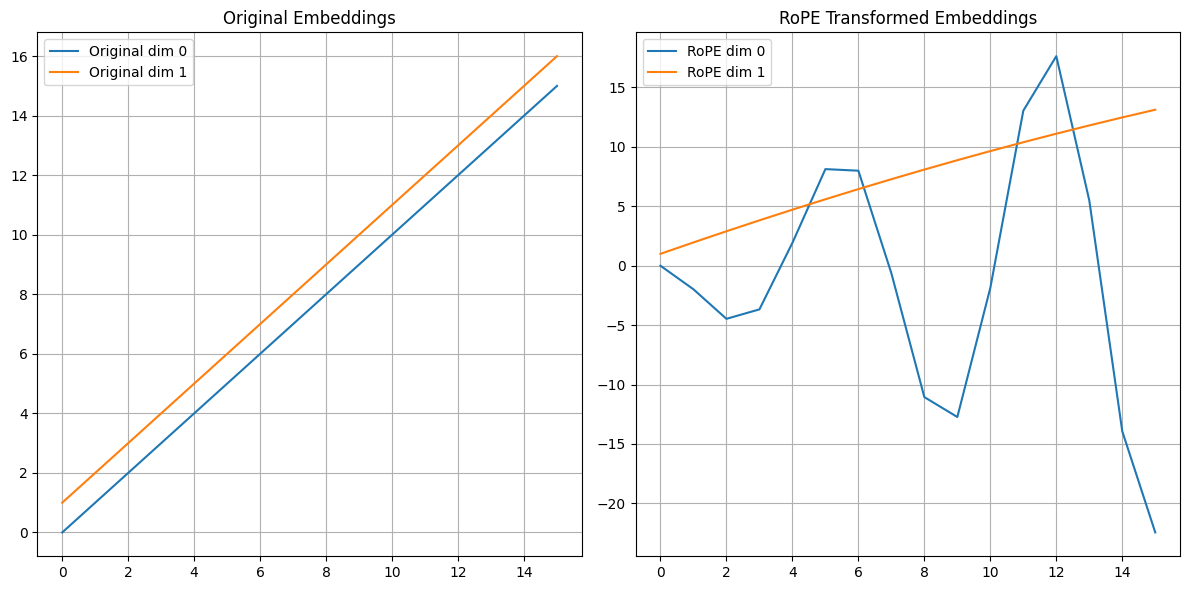


Original values (first 3 positions, all features):
tensor([[0., 1., 2., 3.],
        [1., 2., 3., 4.],
        [2., 3., 4., 5.]])

Transformed values (first 3 positions, all features):
tensor([[ 0.0000,  1.0000,  2.0000,  3.0000],
        [-1.9841,  1.9599,  2.4624,  4.0198],
        [-4.4695,  2.8994,  0.1540,  5.0590]])

Single position test:
Input: torch.Size([1, 1, 1, 4])
Output: torch.Size([1, 1, 1, 4])
Values: tensor([1., 1., 1., 1.])


In [22]:
def create_test_sequence(seq_len=8, d_model=4):
    # Create a sequence that increases along both sequence and feature dimensions
    x = torch.zeros(seq_len, 1, 1, d_model)
    for i in range(seq_len):
        for j in range(d_model):
            x[i, 0, 0, j] = i + j
    return x

# Visualize the embeddings before and after RoPE
def visualize_rope_effect(original, transformed, feature_dim=0):
    plt.figure(figsize=(12, 6))
    
    # Plot original values
    plt.subplot(1, 2, 1)
    plt.plot(original[:, 0, 0, feature_dim].numpy(), label=f'Original dim {feature_dim}')
    plt.plot(original[:, 0, 0, feature_dim+1].numpy(), label=f'Original dim {feature_dim+1}')
    plt.title('Original Embeddings')
    plt.legend()
    plt.grid(True)
    
    # Plot transformed values
    plt.subplot(1, 2, 2)
    plt.plot(transformed[:, 0, 0, feature_dim].numpy(), label=f'RoPE dim {feature_dim}')
    plt.plot(transformed[:, 0, 0, feature_dim+1].numpy(), label=f'RoPE dim {feature_dim+1}')
    plt.title('RoPE Transformed Embeddings')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Test the RoPE transformation
seq_len = 16
d_model = 4  # Must be even
x = create_test_sequence(seq_len, d_model)

rope = RotaryPositionalEmbeddings(d=d_model)
x_transformed = rope(x)

# Visualize the first pair of dimensions
visualize_rope_effect(x, x_transformed, feature_dim=0)

# Print some sample values
print("\nOriginal values (first 3 positions, all features):")
print(x[:3, 0, 0, :])
print("\nTransformed values (first 3 positions, all features):")
print(x_transformed[:3, 0, 0, :])

# Test different sequence positions
test_pos = torch.tensor([[[[1.0, 1.0, 1.0, 1.0]]]])  # Single position test
print("\nSingle position test:")
print("Input:", test_pos.shape)
print("Output:", rope(test_pos).shape)
print("Values:", rope(test_pos)[0, 0, 0])